# Матчинг товаров маркетплейса

#### Цель - найти топ-5 похожих товаров на исходный, один из которых должен быть также оценен асессором как релевантный.

## Cодержание

#### 1. [Исследование и предобработка данных](#1)
#### 2.[Первый этап - отбор топ-100 кандидатов на основе косинусного расстояния](#2)
#### 3.[Второй этап - ранжирование](#3)
#### 4.[Проверка на тестовой выборке](#4)
#### 5.[Вывод](#5)

<a id='1'></a>
### 1. Исследование и предобработка данных

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import faiss

import lightgbm

import optuna

from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

In [2]:
df_base = pd.read_csv('base.csv', index_col=0)
df_train = pd.read_csv('train.csv', index_col=0)
df_validation = pd.read_csv('validation.csv', index_col=0)
df_answers = pd.read_csv('validation_answer.csv', index_col=0)

In [3]:
with pd.option_context('display.max_columns', 100):
    display(df_base.sample(5))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
863881-base,-110.474640,9.155508,-45.298500,-134.02533,128.419070,-84.117980,44.420645,-100.682106,127.11427,109.925610,-151.49901,-51.476050,-25.192427,-23.874880,159.151610,-16.085281,-7.746787,-30.580027,-153.195620,-79.020035,-99.230080,1507.231274,-76.314750,45.875603,8.417295,366.779583,-114.954780,16.313902,-195.045440,157.54340,30.139626,-133.78752,115.585360,-480.733412,42.512703,97.603780,-46.942330,-141.66966,-109.249440,-37.545307,-14.227793,2.408619,-34.387215,26.967323,-47.166102,42.382313,-164.606800,-129.021500,100.204834,4.926899,-118.892210,13.182205,59.658100,-129.672440,91.16251,79.516680,-135.379070,18.143394,-66.109770,-246.509736,-11.664471,-121.71520,-35.03390,47.093204,-169.13275,-44.738831,65.930110,32.017807,-43.017212,123.080100,-1074.464888,-63.883698
2859986-base,-80.243820,10.238382,-49.880980,-117.64261,137.602250,-56.595863,-593.872880,-17.153952,126.01108,160.644600,-164.66026,-125.991380,2.747642,42.835014,148.356600,-13.912071,-6.328743,-58.270210,-150.275330,-79.237750,-90.509930,906.000914,-3.513432,60.250420,22.084354,813.770071,-71.650055,15.741432,-121.120400,143.66700,10.954782,-104.17507,80.328570,-380.389746,51.783432,112.728424,-34.897865,-145.96768,-120.416390,-61.423286,-4.023318,5.290081,-54.368134,71.338070,-42.980374,31.249617,-45.189133,-136.998020,80.090485,-68.289180,-94.333190,-8.676773,56.953470,-20.195724,83.93095,77.307020,-143.000700,-102.886380,-142.942410,-323.957480,19.640953,-138.07576,-28.10867,47.755028,-201.33913,-43.956390,68.637190,57.106007,172.603330,134.799590,-1074.464888,-19.684170
1508092-base,-74.883354,5.895337,-44.192173,-148.90536,107.723910,-39.357260,-717.942254,-32.832207,118.84058,-16.061462,-142.52988,-109.635360,-66.481860,4.254414,151.773070,-2.115299,22.904232,-54.180540,-119.251076,-79.253390,-90.411900,1507.231274,-26.639788,55.129986,34.302150,813.770071,121.869446,20.967720,-79.139590,141.14484,2.403275,-165.56242,48.006844,-735.671365,52.488120,104.504590,10.313620,-140.97272,-122.935974,-71.128660,-6.966566,0.420959,-76.307274,133.537280,-39.428445,88.786450,-204.423070,-63.201424,-4.213608,90.396904,71.058014,-38.746048,66.122040,-126.394720,83.40352,78.404854,-132.924820,96.963680,-58.721820,-372.780086,-62.835660,-137.70926,-108.72027,0.119759,-240.11502,12.557288,67.927574,27.209923,95.659706,96.261444,75.791701,-12.254009
4200838-base,-81.804596,8.901291,-4.103458,-152.76932,95.644290,-69.812100,-530.124724,154.076610,109.75983,199.317700,-125.70070,-44.675034,-74.656975,-26.265577,184.240130,-35.630560,30.037777,-67.856080,-129.124250,-79.372850,-61.384200,682.404444,-59.062830,37.593590,-67.305954,813.770071,-25.792694,7.874653,-79.332370,154.44100,-7.828761,-112.77843,89.713234,-434.004497,134.422840,81.314430,-7.482068,-150.00624,-106.335640,-46.999493,-9.129118,11.972172,-106.864700,82.262535,-41.773886,77.626305,-112.374440,-120.054750,0.943321,8.403355,52.107230,90.721080,84.451730,-224.375900,84.90177,62.782610,-121.302890,32.316593,-34.720177,-653.968500,-20.285126,-137.00124,-98.08905,34.990818,-133.58754,93.180394,69.251080,14.095397,233.661470,112.272490,-994.024533,-87.173540
2890348-base,-105.354614,16.708267,-19.509990,-124.97972,53.175747,-90.220120,-334.857497,72.393480,118.90315,65.750310,-107.90622,-81.317290,-22.343924,49.743088,-15.266983,-13.634906,15.309418,73.649506,-148.203220,-79.178480,-108.028114,709.057004,5.819132,67.163720,41.350510,813.770071,-100.634995,12.874127,-48.230843,155.78407,-11.878211,-163.91794,63.382164,-505.853646,45.672546,72.386800,-22.471165,-153.88725,-103.639910,-48.080692,-8.662259,-4.737662,-153.167540,175.485960,-44.417447,87.229950,-194.065580,-198.960070,44.440630,5.846062,82.645744,48.001793,42.91253

#### Гистограммы распределения признаков

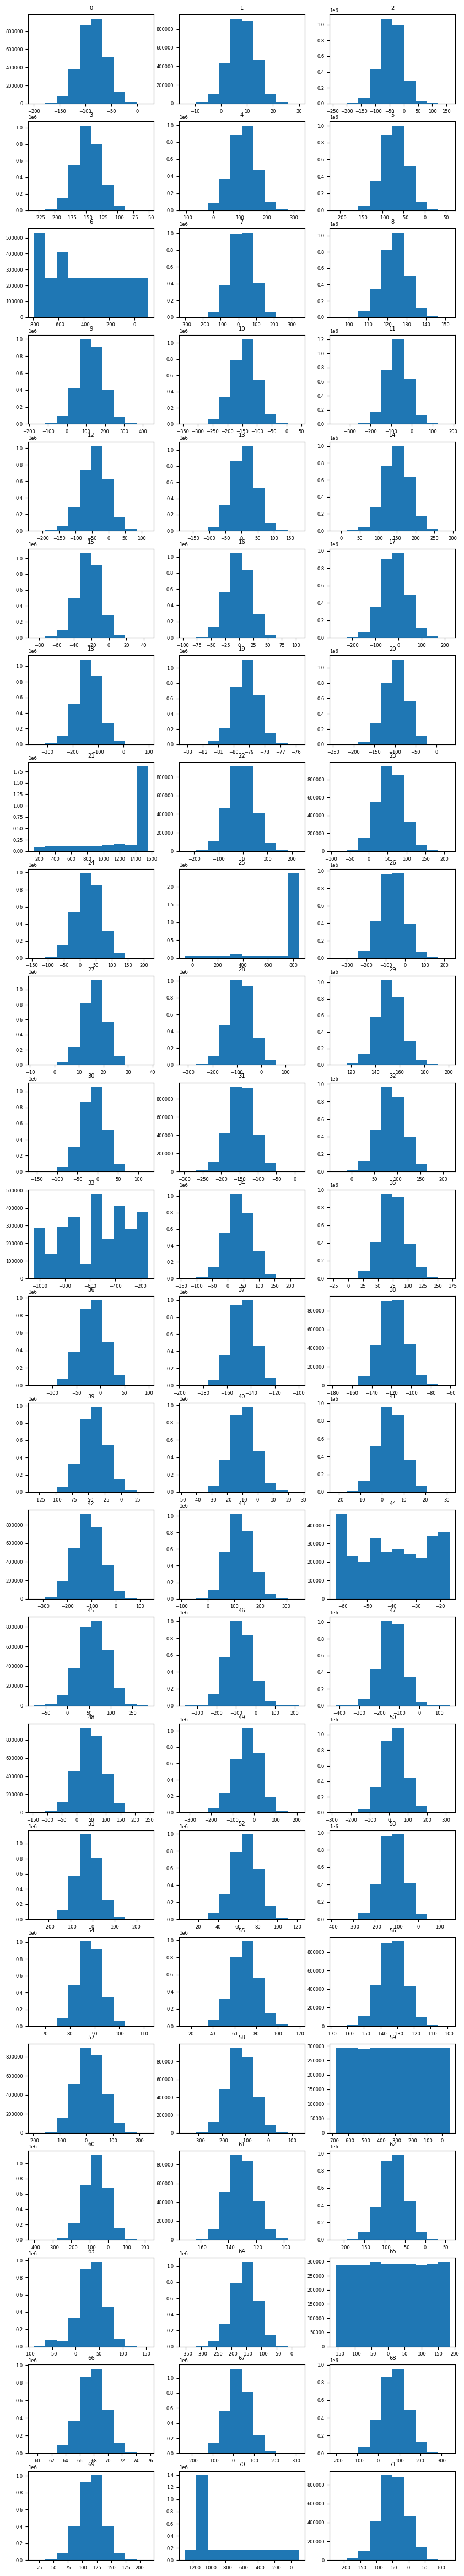

In [4]:
fig = plt.figure(figsize=(10,60))
plt.rc('font', size= 6)
for idx, col in zip(range(72), df_base.columns):
    fig.add_subplot(24, 3, idx+1)
    plt.hist(df_base[col])
    plt.title(col)

In [5]:
with pd.option_context('display.max_columns', 100):
    display(df_base.describe())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,-1.431396e+02,-6.988662e+01,-4.126493e+01,7.587780e+00,1.489852e+02,-2.316701e+01,-9.366916e-01,-1.931312e+01,-1.372712e+02,-7.918932e+01,-9.825383e+01,1.257528e+03,-6.824936e+00,5.667382e+01,2.669563e+01,7.271026e+02,-6.625340e+01,1.631537e+01,-8.637482e+01,1.517346e+02,-1.160764e+01,-1.442328e+02,8.721997e+01,-5.541608e+02,3.623933e+01,7.519918e+01,-1.648670e+01,-1.466421e+02,-1.185122e+02,-4.187896e+01,-9.482269e+00,4.050654e+00,-1.127440e+02,1.208653e+02,-3.980939e+01,5.893878e+01,-8.488885e+01,-1.384695e+02,4.792759e+01,-3.238229e+01,2.658408e+01,-2.171709e+01,6.699684e+01,-1.178976e+02,8.802818e+01,6.920454e+01,-1.329056e+02,1.322645e+01,-1.195996e+02,-3.160935e+02,-6.494332e+01,-1.306677e+02,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,4.168737e+01,5.121991e+01,3.896358e+01,3.659725e+01,3.363559e+01,1.307563e+01,2.083201e+01,5.297210e+01,4.662566e+01,7.574403e-01,2.815861e+01,3.999612e+02,5.197251e+01,3.436061e+01,3.894157e+01,2.055724e+02,6.153334e+01,4.656628e+00,4.851313e+01,1.009000e+01,2.895059e+01,3.475739e+01,2.785556e+01,2.606486e+02,3.989506e+01,2.144713e+01,2.585462e+01,9.953913e+00,1.314411e+01,1.919689e+01,8.190720e+00,5.835750e+00,5.694050e+01,4.671995e+01,1.474482e+01,3.211030e+01,6.319335e+01,5.773822e+01,4.520157e+01,5.828693e+01,5.895291e+01,5.173898e+01,1.307173e+01,5.470584e+01,4.774309e+00,1.194907e+01,7.815245e+00,5.107988e+01,5.524317e+01,2.106644e+02,6.248236e+01,9.569063e+00,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,-3.438436e+02,-3.684526e+02,-2.260906e+02,-1.756239e+02,-1.526698e+01,-8.591711e+01,-9.636816e+01,-2.725656e+02,-3.517478e+02,-8.315235e+01,-2.437279e+02,1.368182e+02,-2.382874e+02,-8.818329e+01,-1.431833e+02,-6.198046e+01,-3.585515e+02,-8.364693e+00,-3.140082e+02,1.074433e+02,-1.567305e+02,-2.986792e+02,-3.465488e+01,-1.045312e+03,-1.378509e+02,-2.151936e+01,-1.379866e+02,-1.954172e+02,-1.769110e+02,-1.327073e+02,-4.757769e+01,-2.158085e+01,-3.381192e+02,-8.770834e+01,-6.310310e+01,-7.724959e+01,-3.629306e+02,-4.186953e+02,-1.453876e+02,-3.228121e+02,-2.802731e+02,-2.646334e+02,6.196133e+00,-3.812643e+02,6.558115e+01,1.408166e+01,-1.670627e+02,-1.961836e+02,-3.597054e+02,-6.810424e+02,-4.007911e+02,-1.713491e+02,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.95094

Имеется набор векторов рамера 72, задача сводится к поиску наименьшего расстояния между векторами, и на основе этого выбора наиболее похожего товара

Признаки под номерами '21', '25', '70' имеют распределение, сосредоточенное по большей части в небольшом диапазоне значений.

In [6]:
df_base.drop(columns=['21', '25', '70'], inplace=True)

Выполним масштабирование данных, чтобы сузить диапазон значений каждого признака. Широкий диапазон плохо влияет на точность моделей, делающий вычисления на основе расстояний.

In [7]:
scaler = StandardScaler()
scaler.fit(df_base);

In [8]:
df_base = pd.DataFrame(scaler.transform(df_base), columns=df_base.columns, index=df_base.index)

In [9]:
df_train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
95432-query,-57.930077,10.959539,-32.153637,-144.77965,80.024055,-79.232834,-221.027495,66.485730,132.21878,153.97614,...,26.761024,-116.725266,160.820792,66.02513,40.874092,137.077320,103.572710,-1074.464888,-54.638470,402020-base
60871-query,-107.838710,5.128239,-42.825780,-151.01651,108.320030,-96.936550,-784.988823,83.282040,125.57025,120.91157,...,17.633270,-133.452180,-91.325431,67.57056,2.442925,-13.245323,85.373170,-1055.934640,-58.504734,487588-base
55561-query,-82.469110,8.606208,-31.322510,-119.20941,131.613660,-64.011246,-405.492920,19.626146,121.38619,171.36903,...,38.568220,-231.936860,-86.568431,69.68204,15.088439,70.234830,133.145400,-998.847337,-38.865772,341046-base
43212-query,-108.262360,1.717479,-135.940080,-134.74443,104.795060,-67.825035,-530.124724,3.066927,129.99200,30.01706,...,47.851532,-126.093420,177.019170,69.49807,-22.719547,93.400800,127.763010,-1059.433775,-25.502810,1401968-base
53808-query,-104.965010,9.537249,-57.706882,-174.53278,78.855804,-118.182785,-67.829124,102.203186,137.11050,141.41374,...,18.205511,-168.372250,-63.132569,67.97744,76.439270,47.068160,84.026306,-1074.464888,-93.366510,1015942-base


In [10]:
with pd.option_context('display.max_columns', 100):
    display(df_train.describe())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,-141.168584,-69.228444,-42.559541,6.506719,149.077582,-23.942253,-2.219093,-12.964439,-138.714610,-79.159795,-97.474574,1297.269578,-3.600685,55.908014,23.470181,742.788817,-64.970553,16.368072,-86.201170,152.098083,-13.659323,-144.506022,89.747894,-587.551768,36.468210,73.109595,-13.866967,-146.487267,-118.336458,-41.131969,-9.261504,4.139978,-104.928806,122.240784,-40.320211,59.051981,-84.054387,-140.787854,46.137851,-34.136875,29.462927,-22.343451,67.581086,-120.052756,88.193676,69.538752,-132.336967,14.452681,-120.301843,-315.282239,-66.378660,-130.672183,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,41.607785,51.258647,40.819544,37.593800,34.167843,13.024184,20.978943,55.210920,48.737245,0.775560,28.382144,375.123794,50.063680,35.617513,40.802653,191.052074,63.160650,4.828575,49.511818,10.392531,29.191689,35.816357,28.312124,273.294442,39.756311,20.008170,25.824911,10.383975,13.578397,19.868303,8.295381,5.922103,56.519443,48.109909,14.739497,31.088173,66.055063,59.851232,46.328286,59.325454,60.934591,54.991787,12.988132,55.920785,4.824051,12.339684,7.952113,49.234745,55.730177,210.657513,64.913422,9.408099,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,-330.570600,-352.405200,-214.742460,-145.860280,8.818390,-82.645004,-91.657020,-247.589280,-326.648740,-82.637184,-228.808260,136.873137,-211.971800,-87.323780,-122.584274,-61.803358,-338.562500,-6.629074,-285.668700,111.387250,-130.444920,-290.124000,-25.550720,-1044.135662,-119.903810,-11.926712,-124.560380,-193.918150,-166.078460,-123.062420,-43.063824,-18.980648,-324.943570,-67.540375,-63.102401,-64.789690,-327.322720,-365.060880,-129.879180,-280.371830,-250.337570,-236.148470,18.477040,-354.915700,66.068665,18.104557,-161.189320,-183.849880,-330.638180,-681.029305,-358.460450,-169.566400,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,-168.599020,-103.048815,-69.801705,-18.815189,126.369124,-32.379752,-16.455603,-49.612492,-171.661355,-79.656816,-115.407545,1248.126198,-37.047511,31.436791,-5.051067,813.770071,-106.860569,13.187895,-119.613590,145.143008,-32.812503,-168.535163,70.432237,-803.390708,9.505674,59.978086,-30.926924,-153.339210,-127.603408,

Выделим целевую переменную.

In [11]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Также удалим признаки, распределение которых сконцентрировано в близких друг другу величинах.

In [12]:
df_train.drop(columns=['21', '25', '70'], inplace=True)
df_train = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns, index=df_train.index)

<a id='2'></a>
### 2. Первый этап - отбор топ-100 кандидатов на основе косинусного расстояния

Используем библиотеку *Faiss*

In [13]:
base_vectors = np.ascontiguousarray(df_base.values).astype('float32')
target_vectors = np.ascontiguousarray(df_train.values).astype('float32')

In [14]:
index = faiss.index_factory(df_base.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
faiss.normalize_L2(base_vectors)
index.add(base_vectors)
faiss.normalize_L2(target_vectors)
nprobs = 100
distances, indexes = index.search(target_vectors, nprobs)

In [15]:
acc = 0
target_indexes = targets.to_dict()
pos_base_idxs = []
pos_target = []
for target_idx, idx in zip(target_indexes, indexes.tolist()):
    base_vectors = [df_base.index[i] for i in idx] 
    if target_indexes[target_idx] in base_vectors:
        acc += 1
        pos_base_idxs.append(base_vectors)
        pos_target.append(target_idx)
        

print(100 * acc / len(targets))

79.389


Итого, рассчитав accuracy@100 получили 79,4 % верно определенных топ-100 похожив товаров на исходные из *train*.

<a id='3'></a>
### 3. Второй этап - ранжирование

Используем библиотеку *LightGBMRanker*

#### Подготовка данных
Для обучения классификатора выберем только положительные результаты из предыдущего этапа, то есть те, где соответствие одного из топ-100 векторов исходному было верно определено.

In [16]:
df_train_pos = df_train.loc[df_train.index.isin(pos_target)]
X = np.array(
    [[i] * nprobs for i in df_train_pos.values]).reshape(
    df_train_pos.shape[0] * nprobs, df_train_pos.shape[1]
    )    
X_idx = np.array(
    [[idx] * 100 for idx in pos_target]).reshape(
    df_train_pos.shape[0] * nprobs
    )
pos_base_100 = np.array(
    [df_base.loc[i].values for i in pos_base_idxs]).reshape(
    df_train_pos.shape[0] * nprobs, df_train_pos.shape[1]
    )        
X = X - pos_base_100
pos_base_idxs = np.array(pos_base_idxs).reshape(df_train_pos.shape[0] * nprobs)

In [17]:
y = []
for num in range(X.shape[0]):
    if targets[X_idx[num]] == pos_base_idxs[num]:
        y.append(1)
    else:
        y.append(0)
       

#### Отбор гиперпараметров с помощью optuna

In [18]:
X_train, X_test, y_train, y_test = X[:2646400], X[2646400:], y[:2646400], y[2646400:]

In [19]:
qids = np.full((X.shape[0]//100), nprobs)
qids_train = np.full((X_train.shape[0]//100), nprobs)
qids_test = np.full((X_test.shape[0]//100), nprobs)

In [20]:
# try parameter tuning
def objective(trial):
    # search param
    param = {
        'reg_alpha': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1), 
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100) 
    }
     
    #train model
    model = lightgbm.LGBMRanker(n_estimators=100, **param, random_state=123, verbose=-1)
    model.fit(
        X_train,
        y_train,
        group=qids_train,
        eval_set=[(X_test, y_test)],
        eval_group=[qids_test],

    )
    
    # maximize mean ndcg
    scores = []
    for name, score in model.best_score_['valid_0'].items():
        scores.append(score)

    return np.mean(scores)

In [21]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=123) #fix random seed
                           )
study.optimize(objective, n_trials=10)

In [22]:
params = study.best_params

В качестве вспомонательной метрики ранжирования использована метрика *ndcg@k*

#### Тренировка модели 

In [23]:
model = lightgbm.LGBMRanker(n_estimators=100, **params, random_state=123, verbose=-1)
model.fit(X,y,group=qids)

LGBMRanker(colsample_bytree=0.6615576566129001, lambda_l1=6.873244016438327e-05,
           lambda_l2=1.0977475286507312, max_depth=8, min_child_samples=16,
           num_leaves=129, random_state=123, verbose=-1)

In [24]:
pred = model.predict(X, verbose=-1)
df_pred = pd.DataFrame(pred, index=X_idx)
df_pred['target'] = y
df_pred = df_pred.groupby(df_pred.index).apply(lambda x: x.sort_values([0], ascending=False).head(5))
df_pred = df_pred.reset_index(level=[0]).drop('level_0', axis=1)

In [25]:
def boosting_accuracy(df):
    accuracy = 0
    for vec_name in df.index.unique().tolist():
        accuracy += int(1 in df.loc[vec_name]['target'].tolist())
    return accuracy/(len(df)/5) * 100

In [26]:
lgbm_accuracy  = boosting_accuracy(df_pred)
lgbm_accuracy

96.21610046731915

Модель ранжирования предсказывает верно топ-5 векторов с точностью 96,2 % из ранее отбранных верно 79,4.  
Итого точность модели ≈ 76,4.

<a id='4'></a>
### 4. Проверка на тестовой выборке

#### Подготовка данных

In [27]:
df_validation.drop(columns=['21', '25', '70'], inplace=True)
df_validation = pd.DataFrame(scaler.transform(df_validation), columns=df_validation.columns, index=df_validation.index)

#### Определение топ-100 ближаших соседей с помощью косинусного расстояния

In [28]:
valid_vectors = np.ascontiguousarray(df_validation.values).astype('float32')
faiss.normalize_L2(valid_vectors)
distances_val, indexes_val = index.search(valid_vectors, nprobs)

In [30]:
acc = 0
ans_dict = df_answers.squeeze().to_list()
for target, idx in zip(ans_dict, indexes_val.tolist()):
    base_vectors = [df_base.index[i] for i in idx] 
    if target in base_vectors:
        acc += 1
        
print(100 * acc / len(targets))

79.387


#### Отбор топ-5 из топ-100


In [32]:
X_val = np.array(
    [[i] * nprobs for i in df_validation.values]).reshape(
    df_validation.shape[0]*nprobs, df_validation.shape[1]
    )
X_val_idx = np.array(
    [[idx] * nprobs for idx in df_validation.index]).reshape(
    df_validation.shape[0] * nprobs
    )
base_100val = np.array([
    df_base.iloc[i].values for i in indexes_val.tolist()]).reshape(
    df_validation.shape[0]*nprobs, df_validation.shape[1]
       )
X_val = X_val - base_100val
base_indexes = np.array([df_base.index[i] for i in indexes_val]).reshape(df_validation.shape[0] * nprobs)

In [34]:
y_valid = []
for num in range(X_val.shape[0]):
    if df_answers.squeeze()[X_val_idx[num]] == base_indexes[num]:
        y_valid.append(1)
    else:
        y_valid.append(0)

In [35]:
pred_val = model.predict(X_val, verbose=-1)

In [36]:
df_pred_val = pd.DataFrame(pred_val, index=X_val_idx)
df_pred_val['target'] = y_valid
df_pred_val = df_pred_val.groupby(df_pred_val.index).apply(lambda x: x.sort_values([0], ascending=False).head(5))
df_pred_val = df_pred_val.reset_index(level=[0]).drop('level_0', axis=1)

In [37]:
lgbm_accuracy  = boosting_accuracy(df_pred_val)
lgbm_accuracy

74.454

Итоговая метрика accuracy@5 - 74.5%.

<a id='5'></a>
### Вывод



Для предасказания похожих векторов была использована двухэтапная модель машинного обучения.

1 этап - определение топ-100 с наименьшим косинусным расстояниям с помощью модели быстрого поиска ближайших соседей и кластеризации в векторном пространстве - Faiss.  

2 этап - ранжирование топ-100 и определение топ-5 с помощью модели градиентого бустинга LightGBMRanker.  

Точность итоговых предсказаний согласно ключевой метрики accuracy@5 - 74,5%.